In [99]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from scipy import linalg
from scipy.sparse import coo_matrix, dia_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags, diags
import sys
from sys import getsizeof

In [100]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [101]:
# Set parameters.
L = 1.0  # length of the rod
nx = 51  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations
alpha = 1.22e-3  #  thermal diffusivity of the rod
q = 100.0  # temperature gradient on the right side of the rod

# Define the locations along the rod.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial temperature along the rod.
T0 = numpy.zeros(nx)
T0[0] = 100.0

In [130]:
def lhs_operator(N, sigma):
    # Setup the diagonal of the operator.
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1.0 + 1.0 / sigma
    # Setup the upper diagonal of the operator.
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A

In [131]:
def rhs_vector(T, sigma, qdx):

    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += qdx
    return b

In [132]:
def btcs_implicit(T0, nt, dt, dx, alpha, q):
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector(T, sigma, q * dx)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = linalg.solve(A, b)
        # Apply the Neumann boundary condition.
        T[-1] = T[-2] + q * dx
    return T

In [133]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx**2 / alpha  # time-step size
nt = 1000  # number of time steps to compute

# Compute the temperature along the rod.
T = btcs_implicit(T0, nt, dt, dx, alpha, q)

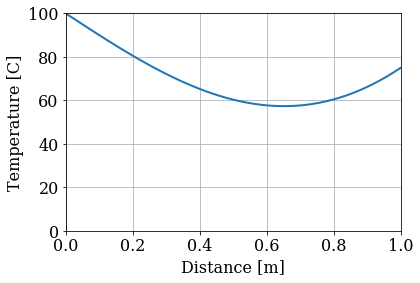

In [134]:
# Plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [135]:
def lhs_operator_sparse(N, sigma):    
    main = numpy.ones(N) * (2.0 + 1.0 / sigma)
    main[-1] = 1.0 + 1.0 / sigma
    upper = numpy.ones(N-1) * -1.0
    lower = numpy.ones(N-1) * -1.0
    diagonals = [[lower],[main],[upper]]
    A = diags(diagonals,[-1,0,1], shape = (N,N))
    #A = dia_matrix(data, diags , N, N)
    return A

In [136]:
def btcs_implicit_sparse(T0, nt, dt, dx, alpha, q):
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator_sparse(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector(T, sigma, q * dx)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = spsolve(A,b)
        # Apply the Neumann boundary condition.
        T[-1] = T[-2] + q * dx
    return T

In [137]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx**2 / alpha  # time-step size
nt = 1000  # number of time steps to compute

# Compute the temperature along the rod.
T_sparse = btcs_implicit_sparse(T0, nt, dt, dx, alpha, q)

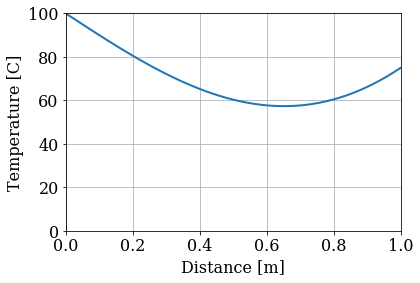

In [138]:
# Plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T_sparse, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [139]:
size = 5000
A_sparse = lhs_operator_sparse(size, 2)
A_dense = lhs_operator(size,2)
sparse_size = sys.getsizeof(A_sparse)
dense_size = sys.getsizeof(A_dense)
print ('Size of dense matrix:', dense_size*1e-6, 'MB')
print ('Size of sparse matrix:', sparse_size*1e-6, 'MB')
print ('Smaller by:', int(dense_size/sparse_size))

Size of dense matrix: 200.000112 MB
Size of sparse matrix: 5.6e-05 MB
Smaller by: 3571430
